## Figure 1

Within-assay perturbation reproducibility and mechanism matching

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(patchwork))

source("viz_themes.R")
source("plotting_functions.R")
source("data_functions.R")

In [2]:
output_figure_base <- file.path("figures", "figure1")
extensions <- c(".png", ".pdf")

### Panel A

In [3]:
results_dir <- file.path("../1.Data-exploration/Profiles_level4/results")

In [4]:
cell_painting_pr_df <- load_percent_replicating(assay = "cellpainting", results_dir = results_dir)
l1000_pr_df <- load_percent_replicating(assay = "l1000", results_dir = results_dir)

pr_df <- dplyr::bind_rows(cell_painting_pr_df, l1000_pr_df)
pr_df$dose <- factor(pr_df$dose, levels = dose_order)

print(dim(pr_df))
head(pr_df)

[1] 63528     4


dose,replicate_correlation,type,assay
<fct>,<dbl>,<chr>,<chr>
0.04 uM,0.06065485,replicate,Cell Painting
0.12 uM,0.03517204,replicate,Cell Painting
0.37 uM,0.06197959,replicate,Cell Painting
1.11 uM,0.07803886,replicate,Cell Painting
3.33 uM,0.14604623,replicate,Cell Painting
10 uM,0.47583989,replicate,Cell Painting


In [5]:
print(dim(cell_painting_pr_df))
print(dim(l1000_pr_df))

[1] 31548     4
[1] 31980     4


In [6]:
threshold_df <- pr_df %>%
    dplyr::filter(type == 'non_replicate') %>%
    dplyr::group_by(assay, dose) %>%
    dplyr::summarise(threshold = quantile(replicate_correlation, 0.95))

percent_replicating_df <- pr_df %>%
    dplyr::left_join(threshold_df, by = c("assay", "dose")) %>%
    dplyr::filter(type == "replicate") %>%
    dplyr::mutate(pass_threshold = threshold < replicate_correlation) %>%
    dplyr::group_by(dose, assay) %>%
    dplyr::summarize(percent_replicating = paste0(100 * round((sum(pass_threshold) / length(pass_threshold)), 4), "%")) %>%
    dplyr::ungroup()

percent_replicating_df

dose,assay,percent_replicating
<fct>,<chr>,<chr>
0.04 uM,Cell Painting,53.18%
0.04 uM,L1000,26.47%
0.12 uM,Cell Painting,58.51%
0.12 uM,L1000,23.98%
0.37 uM,Cell Painting,60.41%
0.37 uM,L1000,28.35%
1.11 uM,Cell Painting,63.59%
1.11 uM,L1000,35.19%
3.33 uM,Cell Painting,68.92%


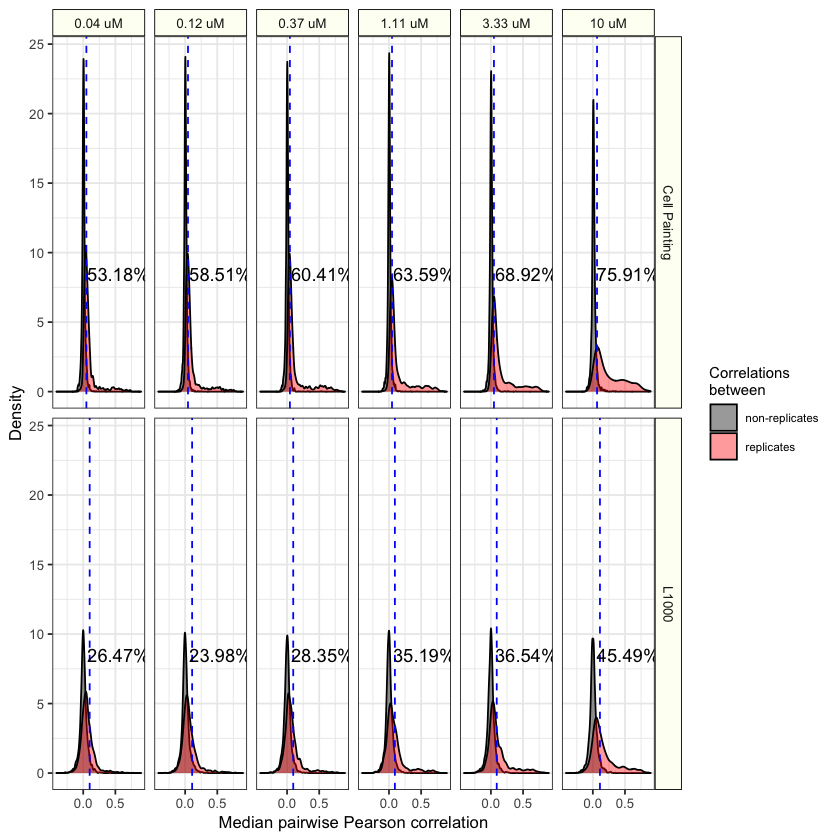

In [7]:
panel_a_gg <- (
    ggplot(pr_df, aes(x = replicate_correlation))
    + geom_density(aes(fill = type), alpha = 0.4)
    + facet_grid("assay~dose")
    + geom_vline(data = threshold_df, linetype = "dashed", color = "blue", aes(xintercept=threshold))
    + geom_text(data = percent_replicating_df, aes(label = percent_replicating, x = 0.55, y = 8.5))
    + theme_bw()
    + figure_theme
    + scale_fill_manual("Correlations\nbetween", labels = replicate_labels, values = replicate_colors)
    + xlab("Median pairwise Pearson correlation")
    + ylab("Density")
)

panel_a_gg

### Panel B

In [8]:
cell_painting_comp_df <- load_median_correlation_scores(assay = "cellpainting", results_dir = results_dir)
l1000_comp_df <- load_median_correlation_scores(assay = "l1000", results_dir = results_dir)

In [9]:
significant_compounds_df <- cell_painting_comp_df %>%
    dplyr::left_join(l1000_comp_df, by = c("dose", "compound"), suffix = c("_cellpainting", "_l1000")) %>%
    tidyr::drop_na() %>%
    dplyr::left_join(threshold_df %>% dplyr::filter(assay == "Cell Painting"), by = "dose") %>%
    dplyr::left_join(threshold_df %>% dplyr::filter(assay == "L1000"), by = "dose", suffix = c("_cellpainting", "_l1000")) %>%
    dplyr::mutate(
        pass_cellpainting_thresh = median_replicate_score_cellpainting > threshold_cellpainting,
        pass_l1000_thresh = median_replicate_score_l1000 > threshold_l1000
    ) %>%
    dplyr::select(compound, dose, pass_cellpainting_thresh, pass_l1000_thresh) %>%
    dplyr::mutate(pass_both = pass_cellpainting_thresh + pass_l1000_thresh) %>%
    dplyr::mutate(pass_both = ifelse(pass_both == 2, TRUE, FALSE))

head(significant_compounds_df)

Warning message:
“Column `dose` joining character vector and factor, coercing into character vector”
Warning message:
“Column `dose` joining character vector and factor, coercing into character vector”


compound,dose,pass_cellpainting_thresh,pass_l1000_thresh,pass_both
<chr>,<chr>,<lgl>,<lgl>,<lgl>
17-hydroxyprogesterone-caproate,0.04 uM,TRUE,FALSE,FALSE
2-iminobiotin,0.04 uM,FALSE,FALSE,FALSE
3-amino-benzamide,0.04 uM,TRUE,FALSE,FALSE
3-deazaadenosine,0.04 uM,FALSE,FALSE,FALSE
ABT-737,0.04 uM,FALSE,FALSE,FALSE
AICA-ribonucleotide,0.04 uM,FALSE,FALSE,FALSE


In [10]:
total_compounds <- length(unique(significant_compounds_df$compound))
total_compounds

[1] 1327

In [11]:
pass_thresh_summary_df <- significant_compounds_df %>%
    dplyr::group_by(dose) %>%
    dplyr::mutate(
        num_pass_cellpainting = sum(pass_cellpainting_thresh),
        num_pass_l1000 = sum(pass_l1000_thresh),
        num_pass_both = sum(pass_both)
    ) %>%
    dplyr::ungroup() %>%
    dplyr::select(dose, num_pass_cellpainting, num_pass_l1000, num_pass_both) %>%
    dplyr::distinct() %>%
    dplyr::mutate(
        unique_pass_cellpainting = num_pass_cellpainting - num_pass_both,
        unique_pass_l1000 = num_pass_l1000 - num_pass_both
    )

pass_thresh_summary_df

dose,num_pass_cellpainting,num_pass_l1000,num_pass_both,unique_pass_cellpainting,unique_pass_l1000
<chr>,<int>,<int>,<int>,<int>,<int>
0.04 uM,707,350,239,468,111
0.12 uM,782,317,216,566,101
0.37 uM,807,376,286,521,90
1.11 uM,850,467,349,501,118
3.33 uM,921,485,403,518,82
10 uM,1015,604,547,468,57


In [12]:
cell_painting_rect <- pass_thresh_summary_df %>%
    dplyr::select(dose, num_pass_cellpainting, unique_pass_cellpainting, num_pass_both) %>%
    dplyr::rename(c(ymax_bar = num_pass_cellpainting, unique_pass = unique_pass_cellpainting)) %>%
    dplyr::mutate(
        ymin_bar = 0,
        xmin_bar = seq(0, (length(unique(pass_thresh_summary_df$dose)) - 1) * 2, 2),
        xmax_bar = seq(1, (length(unique(pass_thresh_summary_df$dose))) * 2, 2),
        assay = "Cell Painting",
        label_text_y = ymax_bar / 4
    )

l1000_rect <- pass_thresh_summary_df %>%
    dplyr::mutate(ymax_bar = num_pass_cellpainting + unique_pass_l1000) %>%
    dplyr::select(dose, ymax_bar, unique_pass_cellpainting, unique_pass_l1000, num_pass_both) %>%
    dplyr::rename(c(ymin_bar = unique_pass_cellpainting, unique_pass = unique_pass_l1000)) %>%
    dplyr::mutate(
        xmin_bar = seq(0, (length(unique(pass_thresh_summary_df$dose)) - 1) * 2, 2),
        xmax_bar = seq(1, (length(unique(pass_thresh_summary_df$dose))) * 2, 2),
        assay = "L1000",
        label_text_y = ymax_bar - 25
    )

full_rect <- dplyr::bind_rows(cell_painting_rect, l1000_rect)

In [13]:
num_pass_both_text <- full_rect %>%
    dplyr::filter(assay == "Cell Painting") %>%
    dplyr::select(dose, xmin_bar, ymax_bar, num_pass_both) %>%
    dplyr::left_join(
        full_rect %>%
            dplyr::filter(assay == "L1000") %>%
            dplyr::select(dose, ymin_bar) %>%
            dplyr::rename(c(ymin_l1000_bar = ymin_bar)),
        by = "dose"
    ) %>%
    dplyr::mutate(label_text_y = ymin_l1000_bar + (num_pass_both / 2))

num_pass_both_text

dose,xmin_bar,ymax_bar,num_pass_both,ymin_l1000_bar,label_text_y
<chr>,<dbl>,<int>,<int>,<dbl>,<dbl>
0.04 uM,0,707,239,468,587.5
0.12 uM,2,782,216,566,674.0
0.37 uM,4,807,286,521,664.0
1.11 uM,6,850,349,501,675.5
3.33 uM,8,921,403,518,719.5
10 uM,10,1015,547,468,741.5


In [14]:
percentile_pass_df <- pass_thresh_summary_df %>%
    dplyr::mutate(
        num_pass_total = unique_pass_l1000 + unique_pass_cellpainting + num_pass_both,
        num_pass_percentile = paste("Total:\n", round(num_pass_total / total_compounds, 4) * 100, "%")
    ) %>%
    dplyr::select(dose, num_pass_percentile, num_pass_total)

In [15]:
# Prep legend order
full_rect <- full_rect %>%
    dplyr::add_row(
        dose = NA,
        ymax_bar = NA,
        unique_pass = NA,
        num_pass_both = NA,
        ymin_bar = NA,
        xmin_bar = NA,
        xmax_bar = NA,
        assay = "Both",
        label_text_y = NA
    ) %>%
    dplyr::left_join(percentile_pass_df, by = "dose")

full_rect$assay <- factor(full_rect$assay, levels = c("L1000", "Both", "Cell Painting"))

In [16]:
full_rect

dose,ymax_bar,unique_pass,num_pass_both,ymin_bar,xmin_bar,xmax_bar,assay,label_text_y,num_pass_percentile,num_pass_total
<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<chr>,<int>
0.04 uM,707,468,239,0,0,1,Cell Painting,176.75,Total: 61.64 %,818
0.12 uM,782,566,216,0,2,3,Cell Painting,195.50,Total: 66.54 %,883
0.37 uM,807,521,286,0,4,5,Cell Painting,201.75,Total: 67.6 %,897
1.11 uM,850,501,349,0,6,7,Cell Painting,212.50,Total: 72.95 %,968
3.33 uM,921,518,403,0,8,9,Cell Painting,230.25,Total: 75.58 %,1003
10 uM,1015,468,547,0,10,11,Cell Painting,253.75,Total: 80.78 %,1072
0.04 uM,818,111,239,468,0,1,L1000,793.00,Total: 61.64 %,818
0.12 uM,883,101,216,566,2,3,L1000,858.00,Total: 66.54 %,883
0.37 uM,897,90,286,521,4,5,L1000,872.00,Total: 67.6 %,897


Warning message:
“Removed 1 rows containing missing values (geom_rect).”
Warning message:
“Removed 1 rows containing missing values (geom_text).”


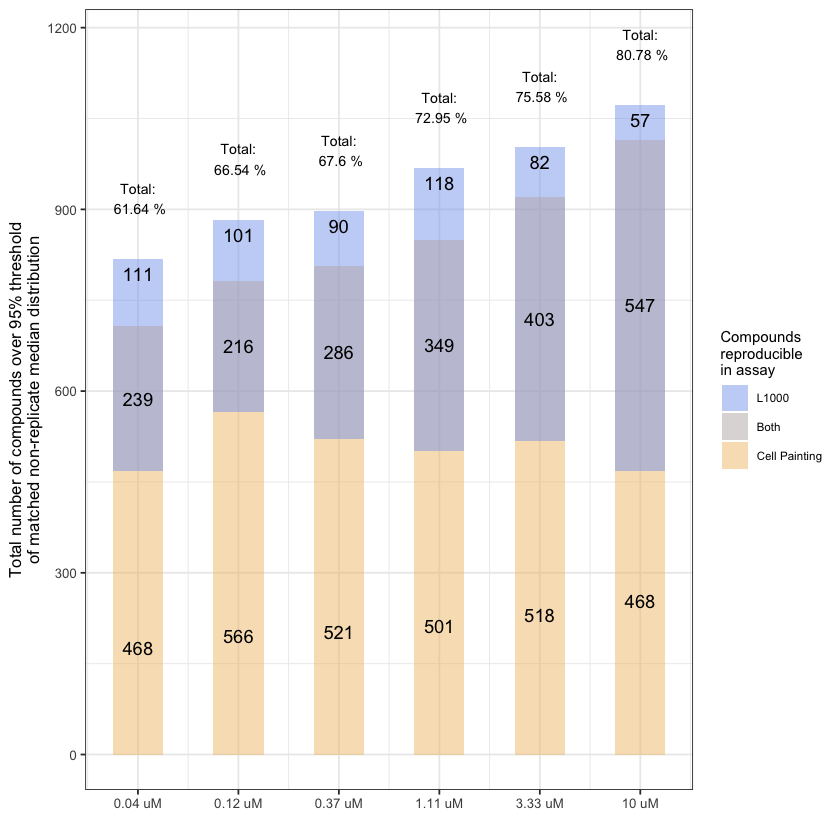

In [17]:
updated_assay_colors <- c(assay_colors, "Both" = "#BDB4B4")

panel_b_gg <- (
    ggplot(full_rect)
    + geom_rect(aes(fill = assay, ymin = ymin_bar, ymax = ymax_bar, xmin = xmin_bar, xmax = xmax_bar), alpha = 0.5)
    + geom_text(aes(x = xmin_bar + 0.5, y = label_text_y, label = unique_pass))
    + geom_text(data = num_pass_both_text, aes(x = xmin_bar + 0.5, y = label_text_y, label = num_pass_both))
    # Select only L1000 below to not duplicate text
    + geom_text(
        data = full_rect %>% dplyr::filter(assay == "L1000"),
        aes(x = xmin_bar + 0.5, y = ymax_bar + 100, label = num_pass_percentile),
        size = 3
    )
    + scale_fill_manual("Compounds\nreproducible\nin assay", values = updated_assay_colors)
    + theme_bw()
    + figure_theme
    + scale_x_continuous(labels = num_pass_both_text$dose, breaks = seq(0.5, length(num_pass_both_text$dose) * 2, 2))
    + ylab("Total number of compounds over 95% threshold\nof matched non-replicate median distribution")
    + xlab("")
    + ylim(0, max(full_rect$num_pass_total, na.rm = TRUE) + 100)

)

panel_b_gg

### Panel C

In [18]:
results_dir <- file.path("../1.Data-exploration/Consensus/")

In [19]:
pm_cellpainting_list <- load_percent_matching(assay = "cellpainting", results_dir = results_dir)
pm_l1000_list <- load_percent_matching(assay = "l1000", results_dir = results_dir)

In [20]:
print(dim(pm_cellpainting_list[["percent_matching"]]))
print(dim(pm_l1000_list[["percent_matching"]]))

[1] 1266    5
[1] 1266    5


In [21]:
print(dim(pm_cellpainting_list[["percent_matching_pvals"]]))
print(dim(pm_l1000_list[["percent_matching_pvals"]]))

[1] 1266    5
[1] 1266    5


In [22]:
p_val_alpha_thresh <- 0.05
no_replicates_thresh <- 3

cell_painting_pm_df <- pm_cellpainting_list[["percent_matching"]] %>%
    dplyr::filter(no_of_replicates >= no_replicates_thresh)
l1000_pm_df <- pm_l1000_list[["percent_matching"]] %>%
    dplyr::filter(no_of_replicates >= no_replicates_thresh)

pm_df <- dplyr::bind_rows(cell_painting_pm_df, l1000_pm_df)

cell_painting_pm_pval_df <- pm_cellpainting_list[["percent_matching_pvals"]] %>%
    dplyr::filter(no_of_replicates >= no_replicates_thresh)
l1000_pm_pval_df <- pm_l1000_list[["percent_matching_pvals"]] %>%
    dplyr::filter(no_of_replicates >= no_replicates_thresh)

pm_pval_df <- dplyr::bind_rows(cell_painting_pm_pval_df, l1000_pm_pval_df)

pm_df <- pm_df %>%
    dplyr::left_join(pm_pval_df, by = c("moa", "dose", "assay", "no_of_replicates")) %>%
    dplyr::mutate(pass_thresh = p_value < p_val_alpha_thresh) %>%
    dplyr::mutate(neg_log_10_p_val = -log10(p_value))

pm_df$dose <- factor(pm_df$dose, levels = dose_order)

pm_df$neg_log_10_p_val[pm_df$neg_log_10_p_val == Inf] = 3.5

print(dim(pm_df))
head(pm_df)

[1] 1524    8


moa,no_of_replicates,dose,matching_score,assay,p_value,pass_thresh,neg_log_10_p_val
<chr>,<dbl>,<fct>,<dbl>,<chr>,<dbl>,<lgl>,<dbl>
acat inhibitor,3,0.04 uM,-0.307784325,Cell Painting,0.876,FALSE,0.05749589
acetylcholine receptor agonist,8,0.04 uM,0.180001558,Cell Painting,0.079,FALSE,1.10237291
acetylcholine receptor antagonist,21,0.04 uM,0.032421545,Cell Painting,0.376,FALSE,0.42481216
adenosine receptor agonist,3,0.04 uM,-0.285657222,Cell Painting,0.853,FALSE,0.06905097
adenosine receptor antagonist,4,0.04 uM,0.180486665,Cell Painting,0.160,FALSE,0.79588002
adrenergic receptor agonist,20,0.04 uM,0.009038156,Cell Painting,0.596,FALSE,0.22475374


In [23]:
percent_matching_df <- pm_df %>%
    dplyr::group_by(assay, dose) %>%
    dplyr::mutate(percent_matching = paste0(100 * round((sum(pass_thresh) / length(pass_thresh)), 4), "%")) %>%
    dplyr::select(dose, assay, percent_matching) %>%
    dplyr::distinct()

percent_matching_df

dose,assay,percent_matching
<fct>,<chr>,<chr>
0.04 uM,Cell Painting,11.02%
0.12 uM,Cell Painting,12.6%
0.37 uM,Cell Painting,14.17%
1.11 uM,Cell Painting,18.11%
3.33 uM,Cell Painting,20.47%
10 uM,Cell Painting,17.32%
0.04 uM,L1000,7.09%
0.12 uM,L1000,9.45%
0.37 uM,L1000,14.96%


In [24]:
# How many compounds per assay per dose with greater than 3 compounds?
for (dose in unique(pm_df$dose)) {
    pm_sub_df <- pm_df %>% dplyr::filter(dose == !!dose)
    print(table(pm_sub_df %>% dplyr::pull(assay)))
}


Cell Painting         L1000 
          127           127 

Cell Painting         L1000 
          127           127 

Cell Painting         L1000 
          127           127 

Cell Painting         L1000 
          127           127 

Cell Painting         L1000 
          127           127 

Cell Painting         L1000 
          127           127 


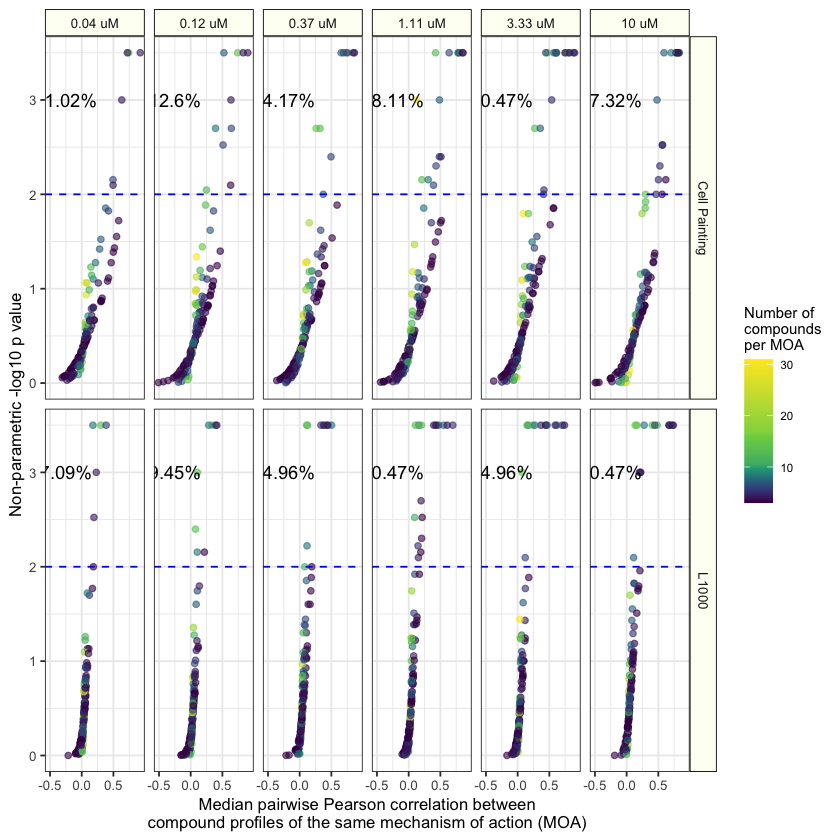

In [25]:
panel_c_gg <- (
    ggplot(pm_df, aes(x = matching_score, y = neg_log_10_p_val))
    + geom_point(aes(color = no_of_replicates), alpha = 0.6)
    + geom_text(data = percent_matching_df, aes(label = percent_matching, x = -0.25, y = 3))
    + facet_grid("assay~dose")
    + geom_hline(linetype = "dashed", color = "blue", yintercept = 2)
    + theme_bw()
    + figure_theme
    + scale_color_continuous("Number of\ncompounds\nper MOA", values = scales::rescale(c(0, 2, 4, 6, 8, 15, 30)), type = "viridis")
    + xlab("Median pairwise Pearson correlation between\ncompound profiles of the same mechanism of action (MOA)")
    + ylab("Non-parametric -log10 p value")
)

panel_c_gg

### Panel D

In [26]:
significant_moa_df <- cell_painting_pm_pval_df %>%
    dplyr::left_join(l1000_pm_pval_df, by = c("dose", "moa"), suffix = c("_cellpainting", "_l1000")) %>%
    tidyr::drop_na() %>%
    dplyr::mutate(
        pass_cellpainting_thresh = p_value_cellpainting < p_val_alpha_thresh,
        pass_l1000_thresh = p_value_l1000 < p_val_alpha_thresh
    ) %>%
    dplyr::select(moa, dose, pass_cellpainting_thresh, pass_l1000_thresh) %>%
    dplyr::mutate(pass_both = pass_cellpainting_thresh + pass_l1000_thresh) %>%
    dplyr::mutate(pass_both = ifelse(pass_both == 2, TRUE, FALSE))

pass_thresh_summary_moa_df <- significant_moa_df %>%
    dplyr::group_by(dose) %>%
    dplyr::mutate(
        num_pass_cellpainting = sum(pass_cellpainting_thresh),
        num_pass_l1000 = sum(pass_l1000_thresh),
        num_pass_both = sum(pass_both)
    ) %>%
    dplyr::ungroup() %>%
    dplyr::select(dose, num_pass_cellpainting, num_pass_l1000, num_pass_both) %>%
    dplyr::distinct() %>%
    dplyr::mutate(
        unique_pass_cellpainting = num_pass_cellpainting - num_pass_both,
        unique_pass_l1000 = num_pass_l1000 - num_pass_both
    )

cell_painting_moa_rect <- pass_thresh_summary_moa_df %>%
    dplyr::select(dose, num_pass_cellpainting, unique_pass_cellpainting, num_pass_both) %>%
    dplyr::rename(c(ymax_bar = num_pass_cellpainting, unique_pass = unique_pass_cellpainting)) %>%
    dplyr::mutate(
        ymin_bar = 0,
        xmin_bar = seq(0, (length(unique(pass_thresh_summary_df$dose)) - 1) * 2, 2),
        xmax_bar = seq(1, (length(unique(pass_thresh_summary_df$dose))) * 2, 2),
        assay = "Cell Painting",
        label_text_y = 2
    )

l1000_moa_rect <- pass_thresh_summary_moa_df %>%
    dplyr::mutate(ymax_bar = num_pass_cellpainting + unique_pass_l1000) %>%
    dplyr::select(dose, ymax_bar, unique_pass_cellpainting, unique_pass_l1000, num_pass_both) %>%
    dplyr::rename(c(ymin_bar = unique_pass_cellpainting, unique_pass = unique_pass_l1000)) %>%
    dplyr::mutate(
        xmin_bar = seq(0, (length(unique(pass_thresh_summary_df$dose)) - 1) * 2, 2),
        xmax_bar = seq(1, (length(unique(pass_thresh_summary_df$dose))) * 2, 2),
        assay = "L1000",
        label_text_y = ymax_bar - 1.5
    )

full_moa_rect <- dplyr::bind_rows(cell_painting_moa_rect, l1000_moa_rect)

num_pass_both_moa_text <- full_moa_rect %>%
    dplyr::filter(assay == "Cell Painting") %>%
    dplyr::select(dose, xmin_bar, ymax_bar, num_pass_both) %>%
    dplyr::left_join(
        full_moa_rect %>%
            dplyr::filter(assay == "L1000") %>%
            dplyr::select(dose, ymin_bar) %>%
            dplyr::rename(c(ymin_l1000_bar = ymin_bar)),
        by = "dose"
    ) %>%
    dplyr::mutate(label_text_y = ymin_l1000_bar + num_pass_both / 2)

In [27]:
total_moas <- length(unique(significant_moa_df$moa))
total_moas

[1] 127

In [28]:
percentile_pass_moa_df <- pass_thresh_summary_moa_df %>%
    dplyr::mutate(
        num_pass_total = unique_pass_l1000 + unique_pass_cellpainting + num_pass_both,
        num_pass_percentile = paste("Total:\n", round(num_pass_total / total_moas, 4) * 100, "%")
    ) %>%
    dplyr::select(dose, num_pass_total, num_pass_percentile)

percentile_pass_moa_df

dose,num_pass_total,num_pass_percentile
<chr>,<int>,<chr>
0.04 uM,20,Total: 15.75 %
0.12 uM,22,Total: 17.32 %
0.37 uM,27,Total: 21.26 %
1.11 uM,34,Total: 26.77 %
3.33 uM,29,Total: 22.83 %
10 uM,32,Total: 25.2 %


In [29]:
# Prep legend order
full_moa_rect <- full_moa_rect %>%
    dplyr::add_row(
        dose = NA,
        ymax_bar = NA,
        unique_pass = NA,
        num_pass_both = NA,
        ymin_bar = NA,
        xmin_bar = NA,
        xmax_bar = NA,
        assay = "Both",
        label_text_y = NA
    ) %>%
    dplyr::left_join(percentile_pass_moa_df, by = "dose")

full_moa_rect$assay <- factor(full_moa_rect$assay, levels = c("L1000", "Both", "Cell Painting"))

Warning message:
“Removed 1 rows containing missing values (geom_rect).”
Warning message:
“Removed 1 rows containing missing values (geom_text).”


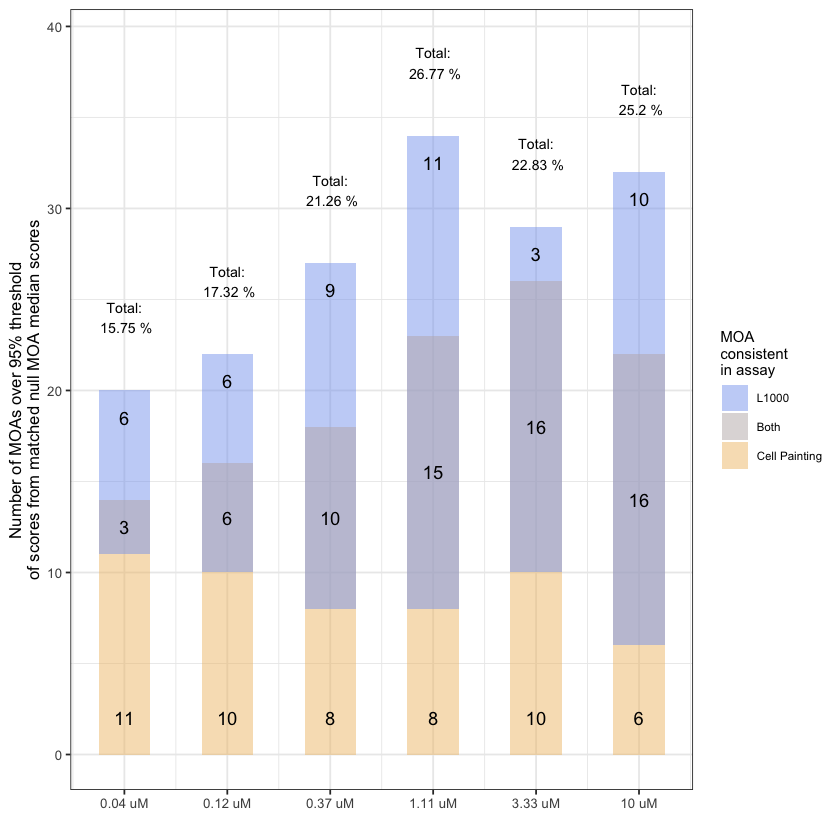

In [30]:
panel_d_gg <- (
    ggplot(full_moa_rect)
    + geom_rect(aes(fill = assay, ymin = ymin_bar, ymax = ymax_bar, xmin = xmin_bar, xmax = xmax_bar), alpha = 0.5)
    + geom_text(aes(x = xmin_bar + 0.5, y = label_text_y, label = unique_pass))
    + geom_text(data = num_pass_both_moa_text, aes(x = xmin_bar + 0.5, y = label_text_y, label = num_pass_both))
    # Select only L1000 below to not duplicate text
    + geom_text(
        data = full_moa_rect %>% dplyr::filter(assay == "L1000"),
        aes(x = xmin_bar + 0.5, y = ymax_bar + 4, label = num_pass_percentile),
        size = 3
    )
    + scale_fill_manual("MOA\nconsistent\nin assay", values = updated_assay_colors)
    + theme_bw()
    + figure_theme
    + scale_x_continuous(
        labels = num_pass_both_moa_text$dose,
        breaks = seq(0.5, length(num_pass_both_moa_text$dose) * 2, 2),
    )
    + ylab("Number of MOAs over 95% threshold\nof scores from matched null MOA median scores")
    + xlab("")
    + ylim(0, max(full_moa_rect$num_pass_total, na.rm = TRUE) + 5)
)

panel_d_gg

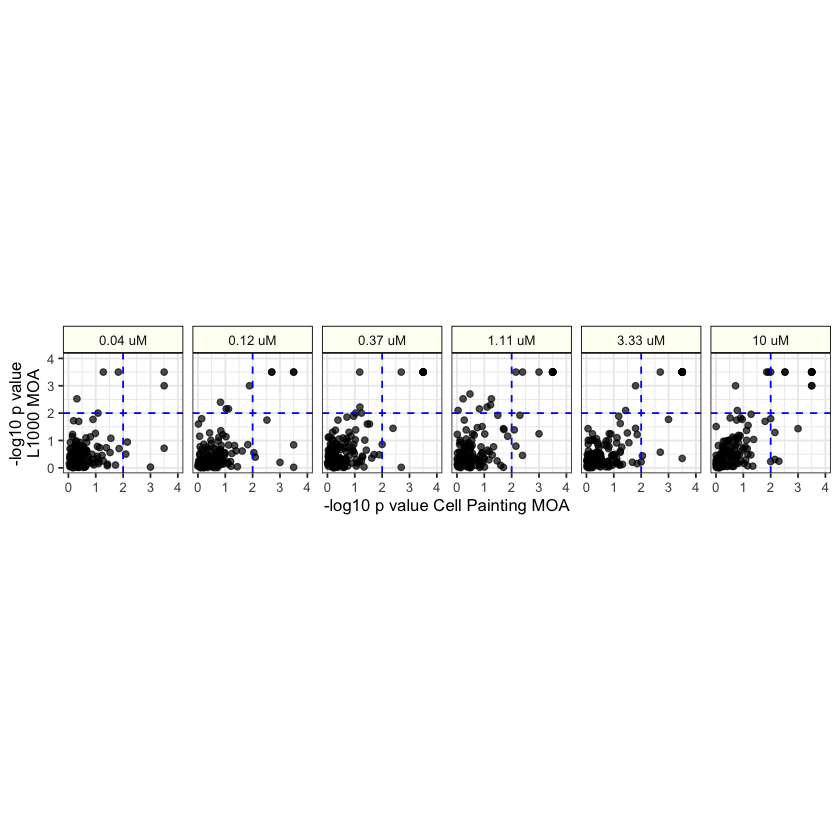

In [31]:
moa_compare_pval_df <- cell_painting_pm_pval_df %>%
    dplyr::left_join(l1000_pm_pval_df, by = c("dose", "moa"), suffix = c("_cellpainting", "_l1000")) %>%
    tidyr::drop_na() %>%
    dplyr::mutate(
        neg_log_10_p_val_cp = -log10(p_value_cellpainting),
        neg_log_10_p_val_l1000 = -log10(p_value_l1000),
        pass_cellpainting_thresh = p_value_cellpainting < p_val_alpha_thresh,
        pass_l1000_thresh = p_value_l1000 < p_val_alpha_thresh
    )

moa_compare_pval_df$neg_log_10_p_val_cp[moa_compare_pval_df$neg_log_10_p_val_cp == Inf] = 3.5
moa_compare_pval_df$neg_log_10_p_val_l1000[moa_compare_pval_df$neg_log_10_p_val_l1000 == Inf] = 3.5

moa_compare_pval_df$dose <- factor(moa_compare_pval_df$dose, levels = dose_order)

sup_maybe_gg <- (
    ggplot(moa_compare_pval_df, aes(x = neg_log_10_p_val_cp, y = neg_log_10_p_val_l1000))
    + geom_point(alpha = 0.7)
    + geom_hline(linetype = "dashed", color = "blue", yintercept = 2)
    + geom_vline(linetype = "dashed", color = "blue", xintercept = 2)
    + figure_theme
    + facet_grid("~dose")
    + coord_fixed()
    + xlab("-log10 p value Cell Painting MOA")
    + ylab("-log10 p value\nL1000 MOA")
    + ylim(c(0, 4))
    + xlim(c(0, 4))
)

sup_maybe_gg

### Compile figure panels together

Warning message:
“Removed 1 rows containing missing values (geom_rect).”
Warning message:
“Removed 1 rows containing missing values (geom_text).”
Warning message:
“Removed 1 rows containing missing values (geom_rect).”
Warning message:
“Removed 1 rows containing missing values (geom_text).”


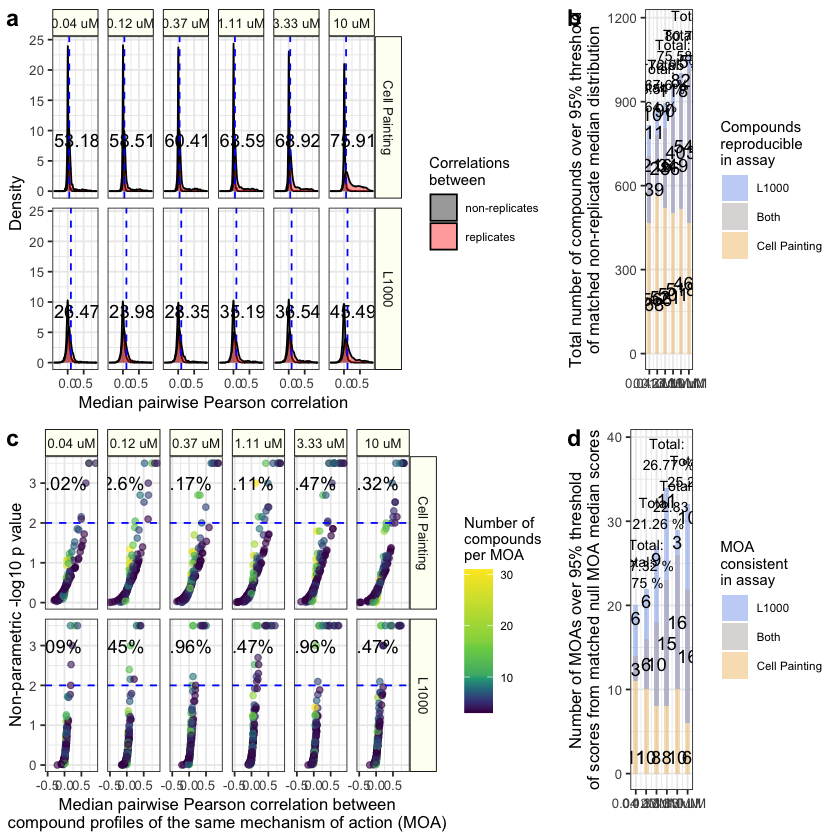

In [32]:
figure_1_gg <- cowplot::plot_grid(
    cowplot::plot_grid(
        panel_a_gg,
        panel_b_gg,
        ncol = 2,
        rel_widths = c(1, 0.5),
        labels = c("a", "b")
    ),
    cowplot::plot_grid(
        panel_c_gg,
        panel_d_gg,
        ncol = 2,
        rel_widths = c(1, 0.5),
        labels = c("c", "d")
    ),
    nrow = 2,
    rel_heights = c(1, 1)
)

figure_1_gg

In [33]:
for (extension in extensions) {
    output_file <- paste0(output_figure_base, extension)
    cowplot::save_plot(output_file, figure_1_gg, base_width = 16, base_height = 8, dpi = 500)
}